In [139]:
# dataset: https://www.kaggle.com/datasets/amitabhajoy/bengaluru-house-price-data
# Project: Bengaluru House price predicator
# ML Algorith Used: LinearRegression

In [140]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, accuracy_score

In [141]:
df = pd.read_csv('Bengaluru_House_Data.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [142]:
df.groupby('area_type')['area_type'].agg('count')

,area_type
area_type,
Built-up Area,2418
Carpet Area,87
Plot Area,2025
Super built-up Area,8790


In [143]:
# droping column area_type due to large number of unique values
df.drop(columns=['area_type'], inplace=True)

In [144]:
df['availability'].value_counts()

,count
availability,
Ready To Move,10581
18-Dec,307
18-May,295
18-Apr,271
18-Aug,200
...,...
15-Aug,1
17-Jan,1
16-Nov,1


In [145]:
# deleting availability due to large number of unique values
df.drop(columns=['availability'], inplace=True)

In [146]:
df['location'].isnull().sum()

1

In [147]:
# filling location null value
df['location'] = df['location'].fillna(df['location'].mode()[0])

In [148]:
df.isnull().sum()

,0
location,0
size,16
society,5502
total_sqft,0
bath,73
balcony,609
price,0


In [149]:
# remove society and balcony due to large number of nan values
df.drop(columns=['society', 'balcony'], inplace=True)

In [150]:
# fill size with mode
df['size'] = df['size'].fillna(df['size'].mode()[0])

In [151]:
# create bhk column from size column
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))
df.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [152]:
# fill bath with mode
df['bath'] = df['bath'].fillna(df['bath'].mode()[0])

In [153]:
# now there is no any null value
df.isnull().sum()

,0
location,0
size,0
total_sqft,0
bath,0
price,0
bhk,0


In [154]:
# checking outlier
df.describe()

,bath,price,bhk
count,13320.000000,13320.000000,13320.000000
mean,2.688814,112.565627,2.802778
std,1.338754,148.971674,1.294496
min,1.000000,8.000000,1.000000
25%,2.000000,50.000000,2.000000
50%,2.000000,72.000000,3.000000
75%,3.000000,120.000000,3.000000
max,40.000000,3600.000000,43.000000


In [155]:
# remove that row where bhk is more than <=15
df = df[df.bhk <= 15]

In [156]:
# removing bath outlier
df = df[df.bath <= 10]

In [157]:
# convert total_sqft to float where  possible
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [158]:
# apply is_float in total_sqrt column
df[~df['total_sqft'].apply(is_float)].head()

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
56,Devanahalli,4 Bedroom,3010 - 3410,2.0,192.000,4
81,Hennur Road,4 Bedroom,2957 - 3450,2.0,224.500,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2


In [159]:
# function for converting range value in total_sqft to average by (min + max)/2
def convert_range_to_avg(x):
    tokens = x.split('-')
    if len(tokens) == 2:
      return (float(tokens[0]) + float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [160]:
# apply convert_range_to_avg in total_sqft column
df['total_sqft'] = df['total_sqft'].apply(convert_range_to_avg)

In [161]:
df.head(10)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2
5,Whitefield,2 BHK,1170.0,2.0,38.00,2
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3
9,Gandhi Bazar,6 Bedroom,1020.0,6.0,370.00,6


In [162]:
# create a column price per squar fit
df['price_per_sqft'] = df['price'] * 100000 / df['total_sqft']
df.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [163]:
# strip location
df['location'] = df['location'].apply(lambda x: x.strip())

In [164]:
# checking location
df.groupby('location')['location'].agg('count').sort_values(ascending=False)

,location
location,
Whitefield,542
Sarjapur Road,399
Electronic City,303
Kanakpura Road,273
Thanisandra,237
...,...
Kasthuri Nagar East Of NGEF,1
Kathriguppe IV Phase,1
Keerthi Layout,1


In [165]:
# count len where location is less than 10
len(df.groupby('location')['location'].agg('count').sort_values(ascending=False)[df.groupby('location')['location'].agg('count').sort_values(ascending=False) <= 10])

1045

In [166]:
# create location category where location count is less than 10
location_count = df['location'].value_counts()
df['location'] = df['location'].apply(lambda x: 'other' if location_count[x] <= 10 else x)

In [167]:
# unique location now
len(df['location'].unique())

242

In [168]:
df.price_per_sqft.describe()

,price_per_sqft
count,1.325400e+04
mean,7.897524e+03
std,1.065087e+05
min,2.678298e+02
25%,4.266667e+03
50%,5.429218e+03
75%,7.302371e+03
max,1.200000e+07


In [169]:
df.shape

(13300, 7)

In [170]:
# function for removing price per sqft outlier
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

In [171]:
# call = remove_pps_outliers
df = remove_pps_outliers(df)
df.shape

(11472, 7)

In [172]:
df.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,6 BHK,1200.0,6.0,125.0,6,10416.666667
3,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
4,1st Block Jayanagar,7 Bedroom,930.0,4.0,85.0,7,9139.784946
5,1st Block Jayanagar,8 Bedroom,700.0,4.0,104.0,8,14857.142857
6,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
7,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668
8,1st Block Jayanagar,4 BHK,2750.0,4.0,413.0,4,15018.181818
9,1st Block Jayanagar,4 BHK,2450.0,4.0,368.0,4,15020.408163


In [173]:
# kepp that rows where total_sqft/bhk >= 300
df = df[(df['total_sqft']/df['bhk']) >= 300]
df.shape

(11025, 7)

In [174]:
df.describe()

,total_sqft,bath,price,bhk,price_per_sqft
count,11025.000000,11025.000000,11025.000000,11025.000000,11025.000000
mean,1557.445405,2.513651,104.096165,2.609887,6049.546130
std,1149.509613,1.003450,136.347834,0.911103,3280.798877
min,300.000000,1.000000,10.000000,1.000000,267.829813
25%,1115.000000,2.000000,49.500000,2.000000,4257.167680
50%,1300.000000,2.000000,68.750000,2.000000,5241.935484
75%,1680.000000,3.000000,109.000000,3.000000,6666.666667
max,52272.000000,10.000000,2912.000000,11.000000,53150.000000


<Axes: ylabel='price_per_sqft'>

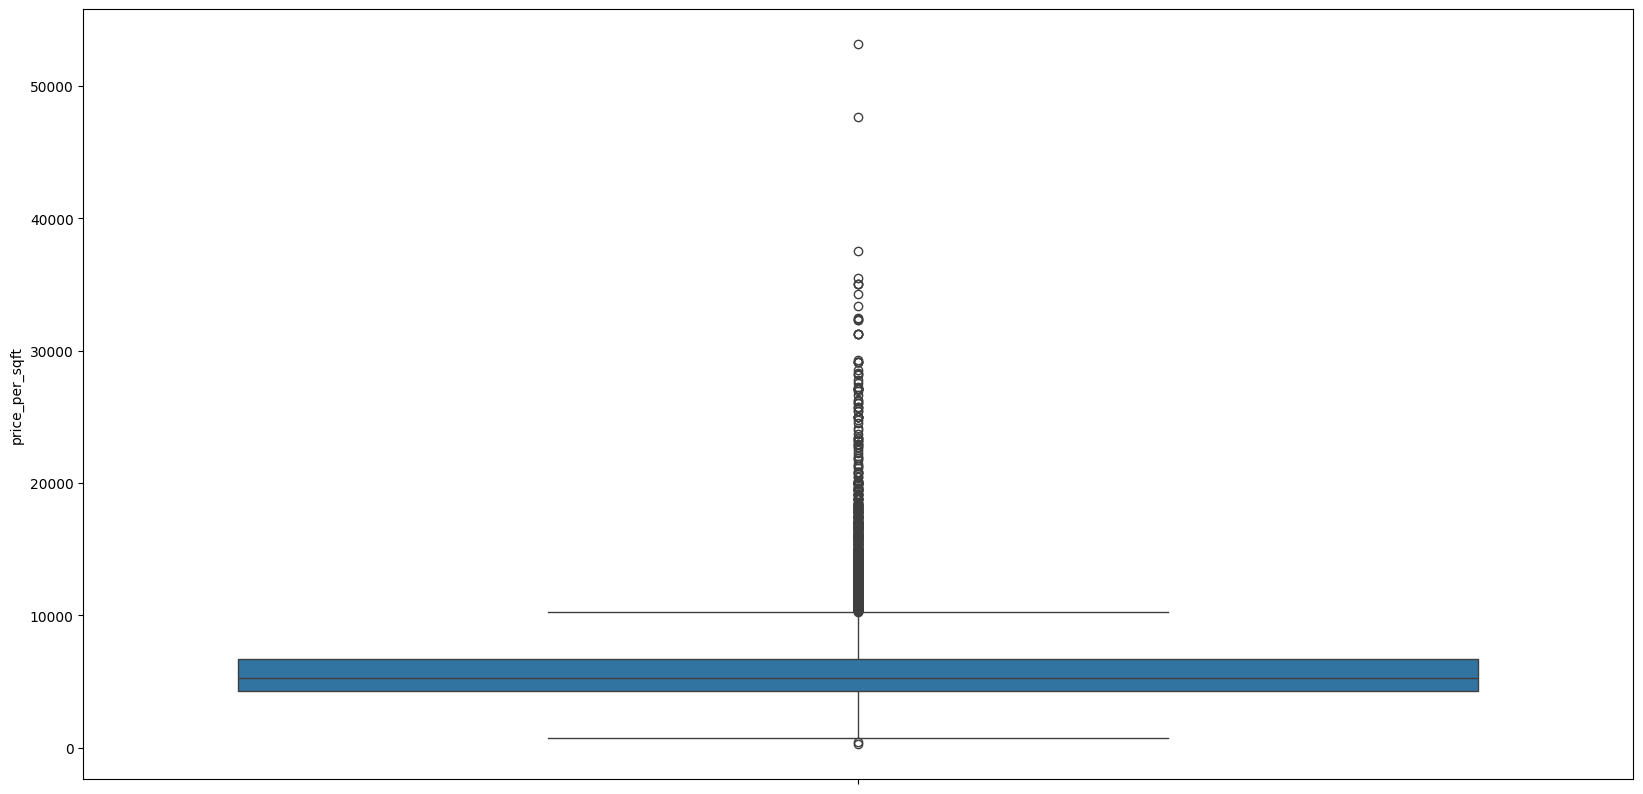

In [175]:
sns.boxplot(df['price_per_sqft'])

<Axes: ylabel='bhk'>

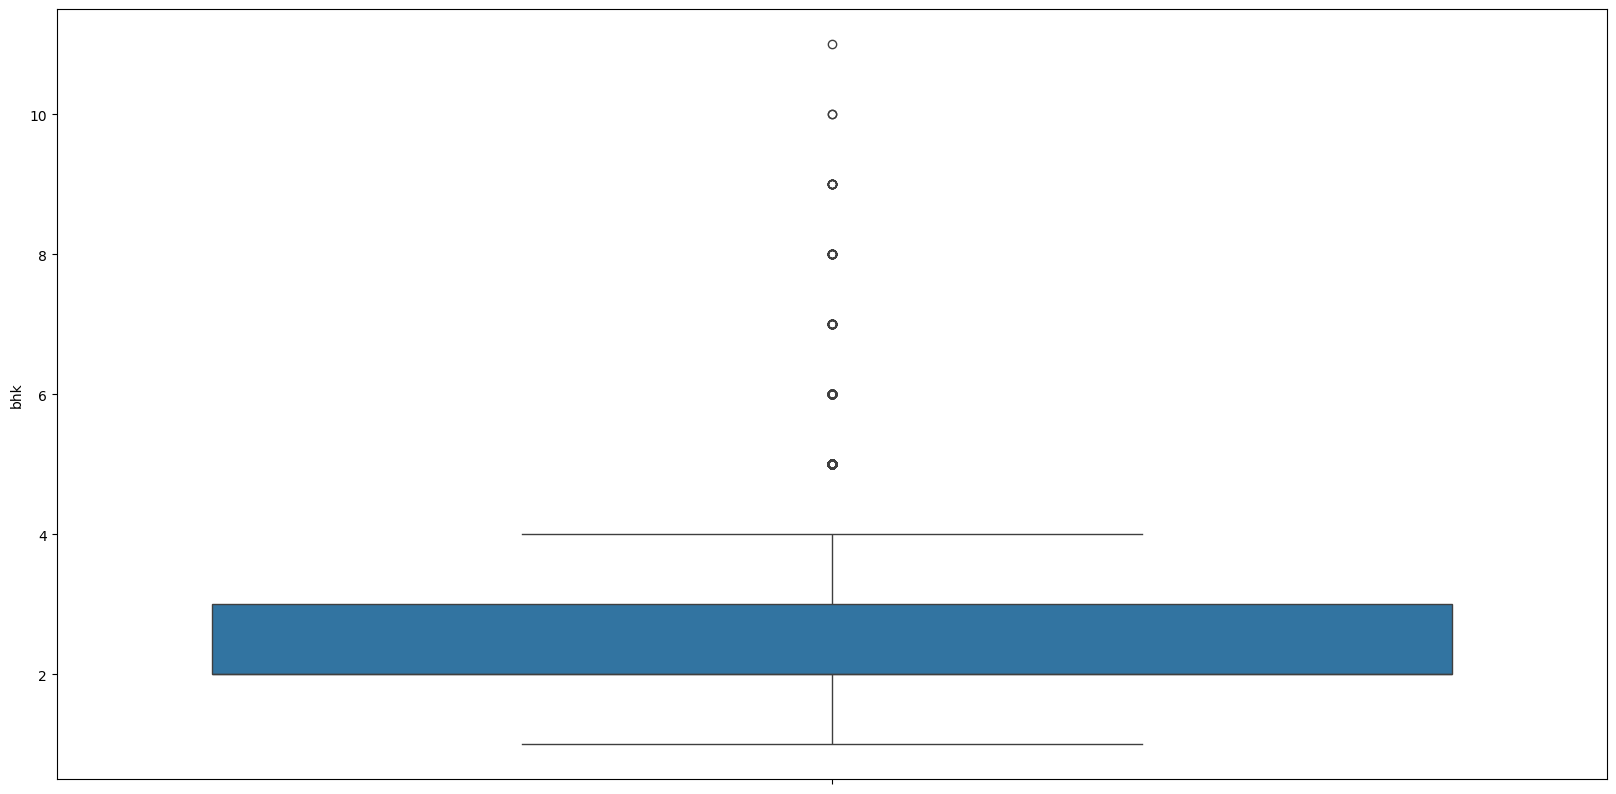

In [176]:
sns.boxplot(df['bhk'])

In [177]:
def remove_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }

        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices,bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)

    return df.drop(exclude_indices, axis='index')

In [178]:
df = remove_outliers(df)

<Axes: ylabel='bhk'>

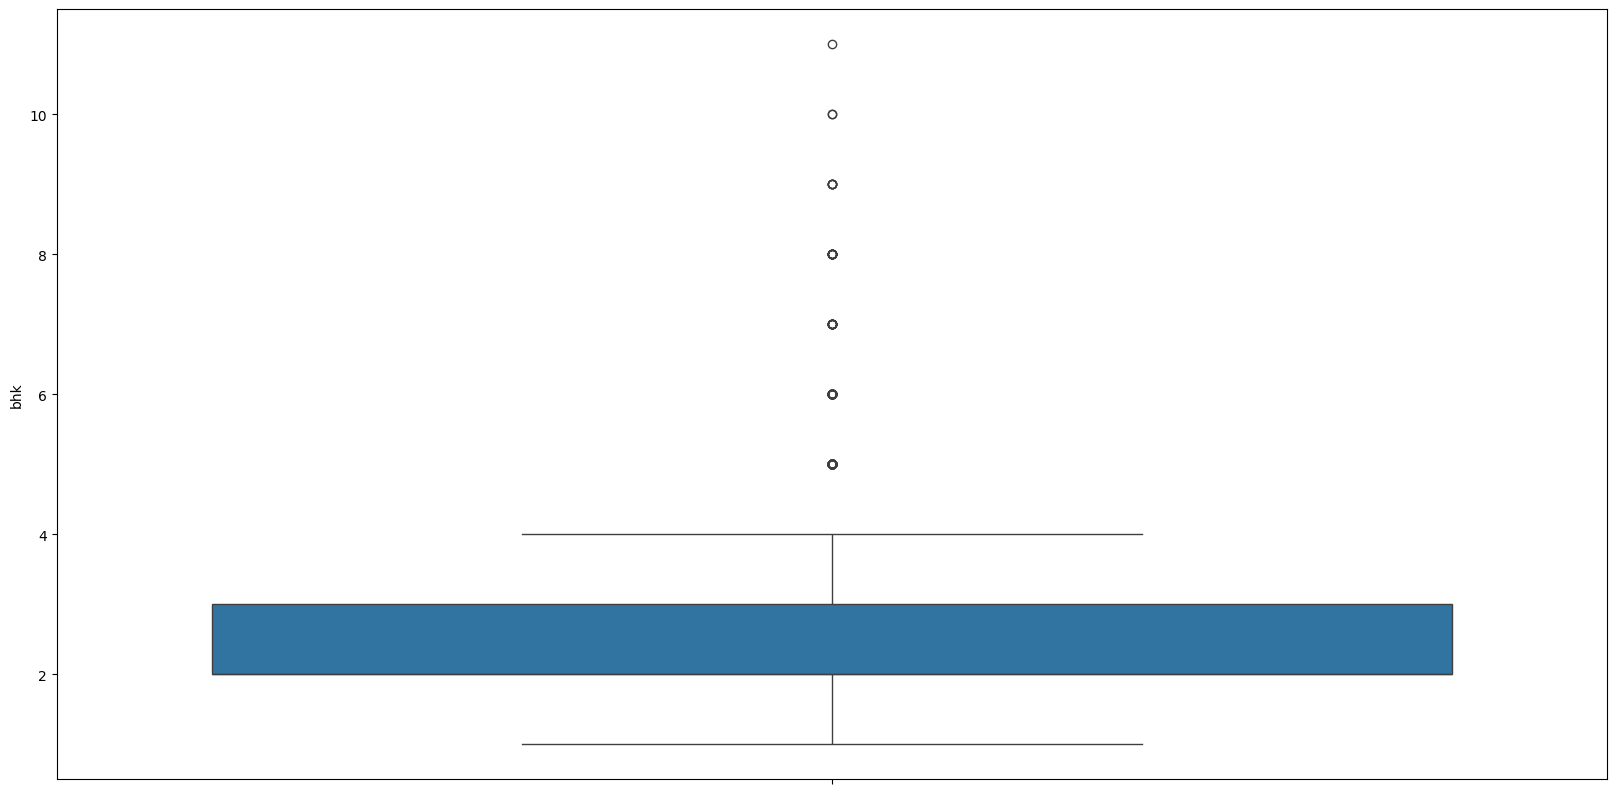

In [179]:
sns.boxplot(df['bhk'])

In [180]:
df.shape

(7722, 7)

In [181]:
# remove that rows where more bathromm than bedromm
df = df[df.bath < df.bhk + 2]
df.shape

(7630, 7)

EDA - Exploratory Data Analysis

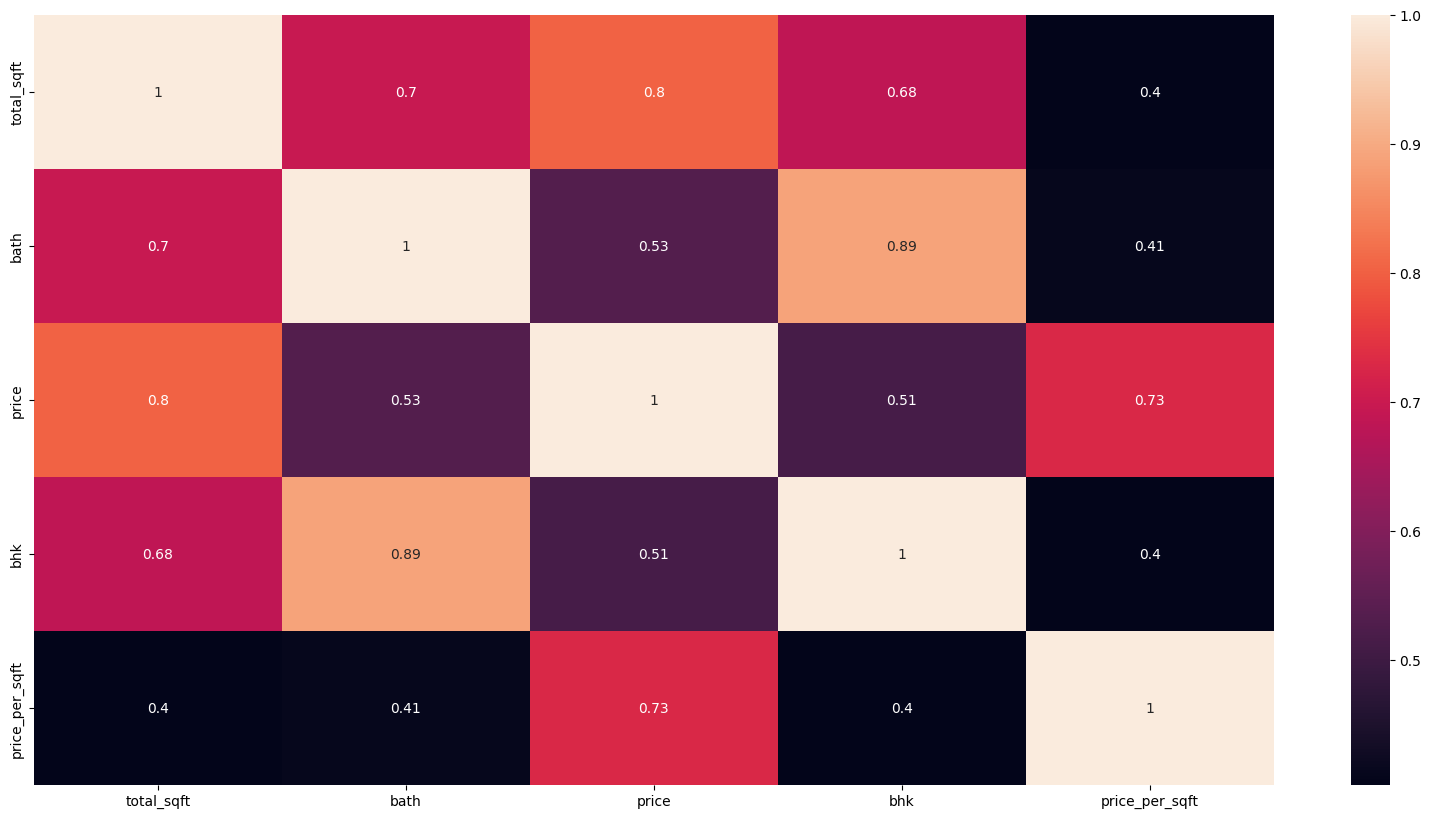

In [182]:
# checking corelation heatmap
plt.figure(figsize=(20,10))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True)
plt.show()

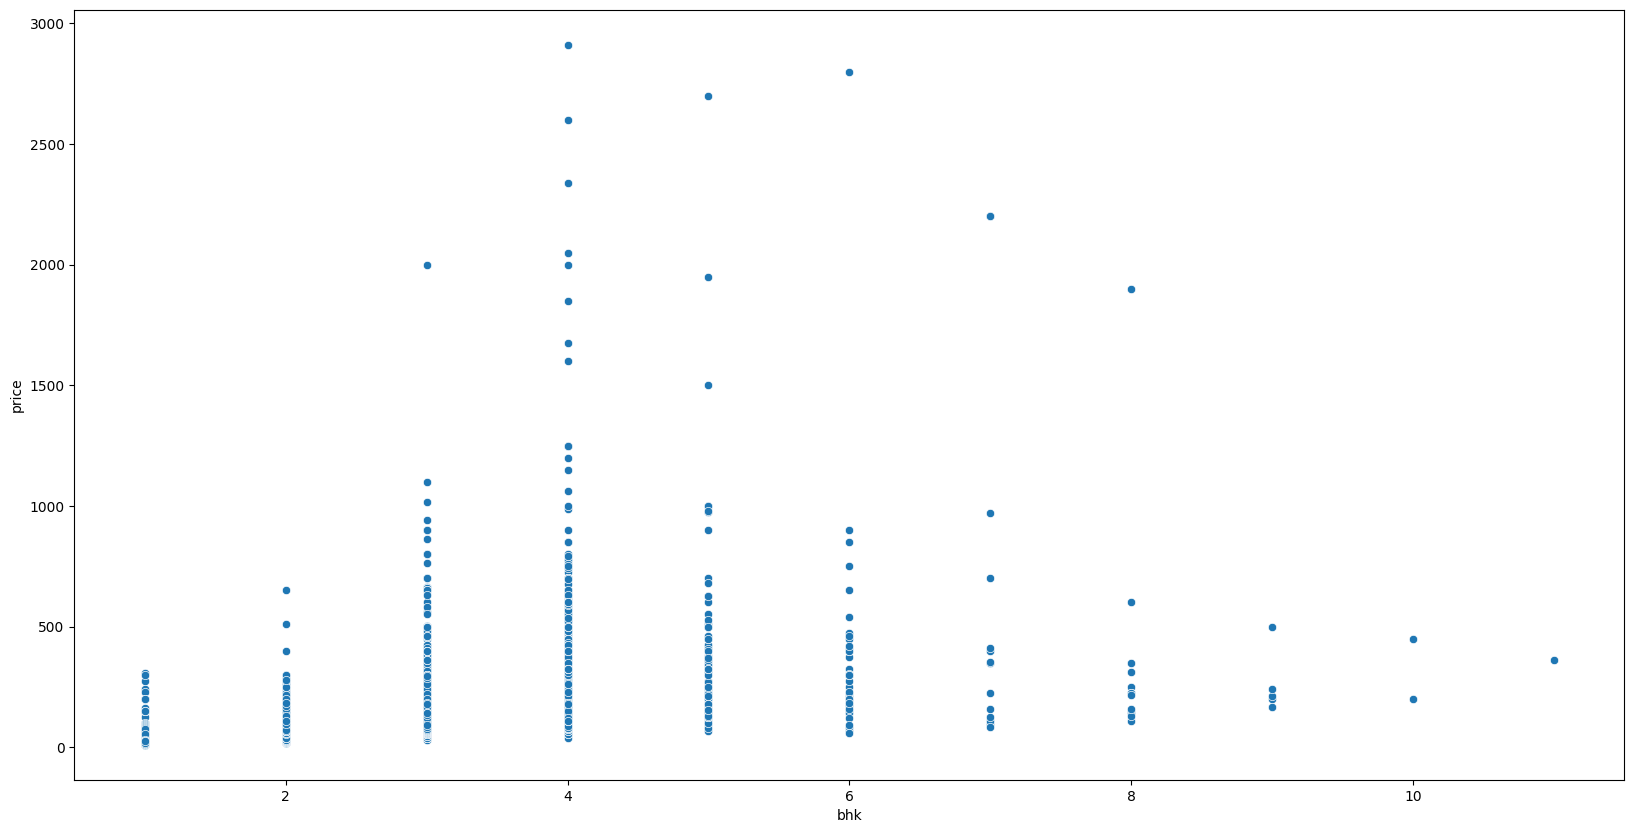

In [183]:
# price vs bhk
plt.figure(figsize=(20,10))
sns.scatterplot(x='bhk', y='price', data=df)
plt.show()

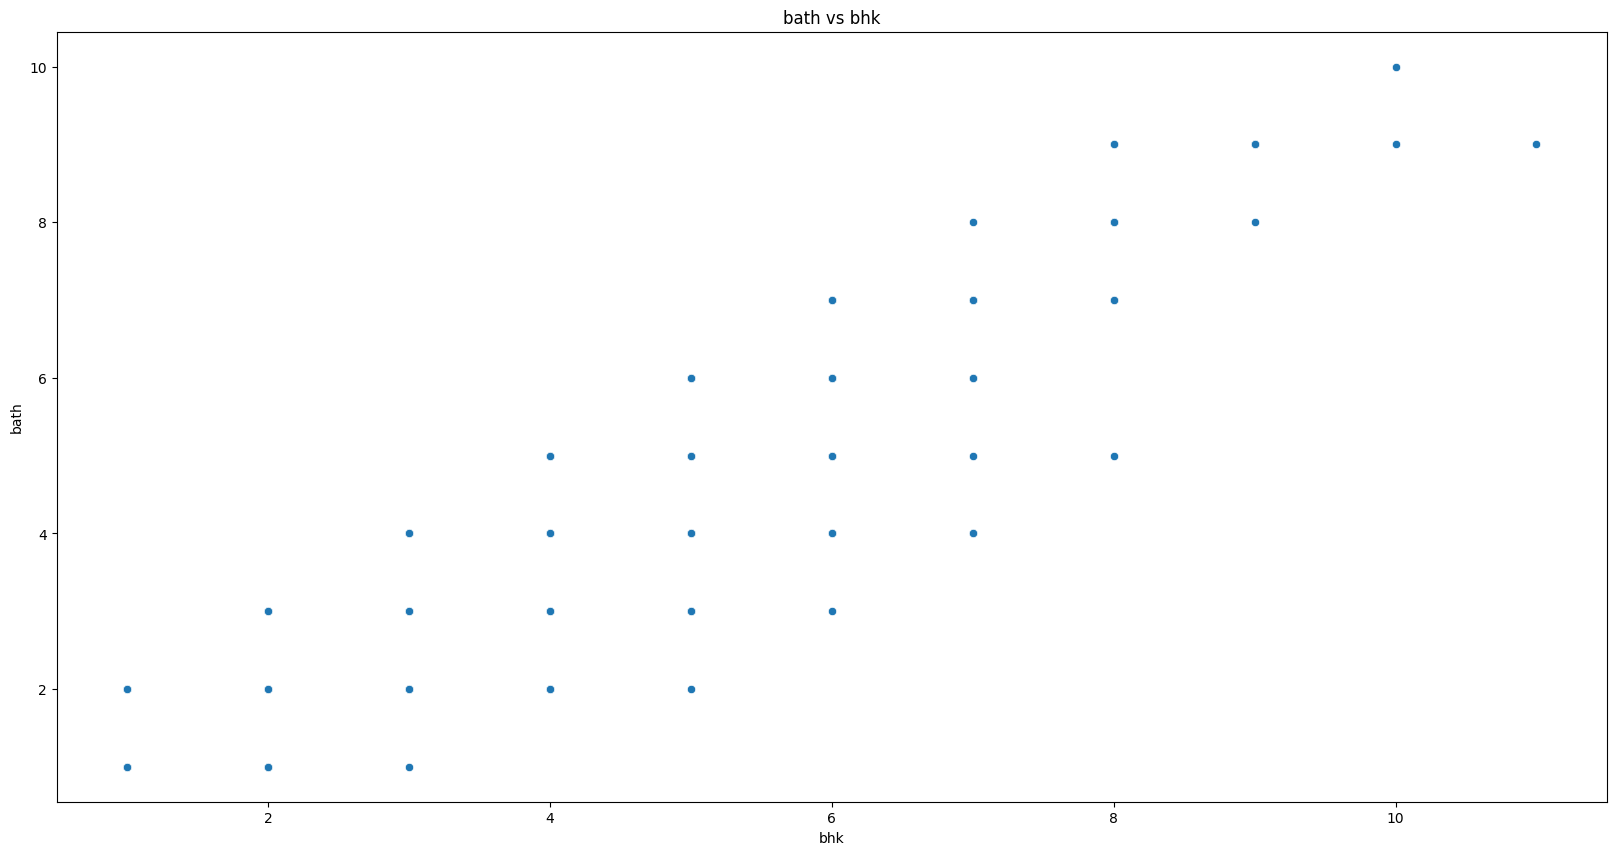

In [184]:
# bath and bhk
plt.figure(figsize=(20,10))
sns.scatterplot(x='bhk', y='bath', data=df)
plt.title('bath vs bhk')
plt.show()

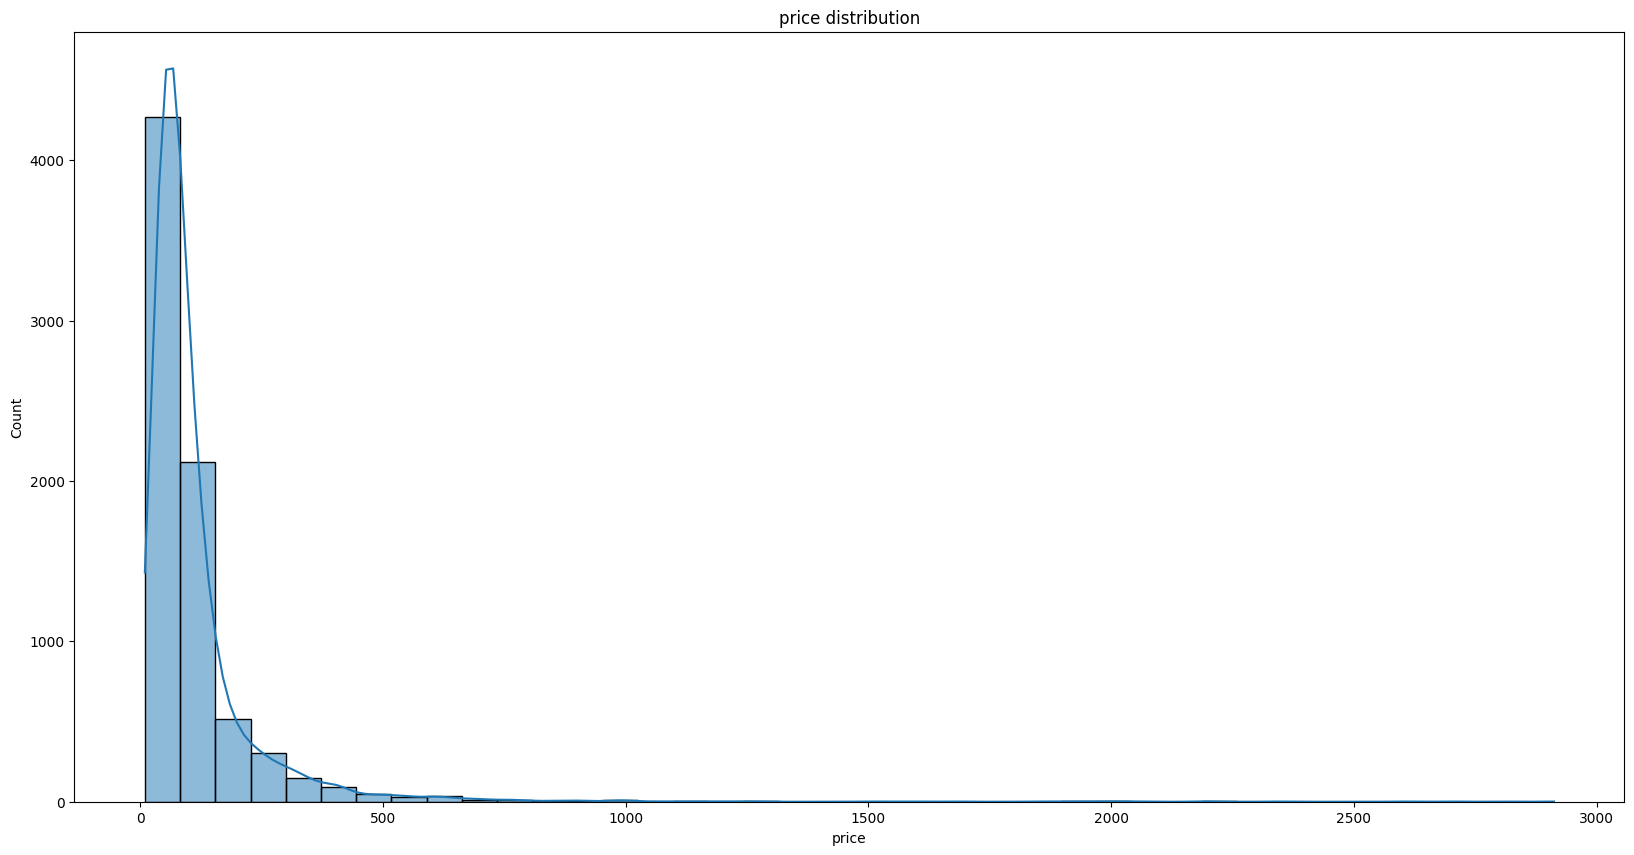

In [185]:
# price distribution
plt.figure(figsize=(20,10))
sns.histplot(df['price'], kde=True, bins=40)
plt.title('price distribution')
plt.show()

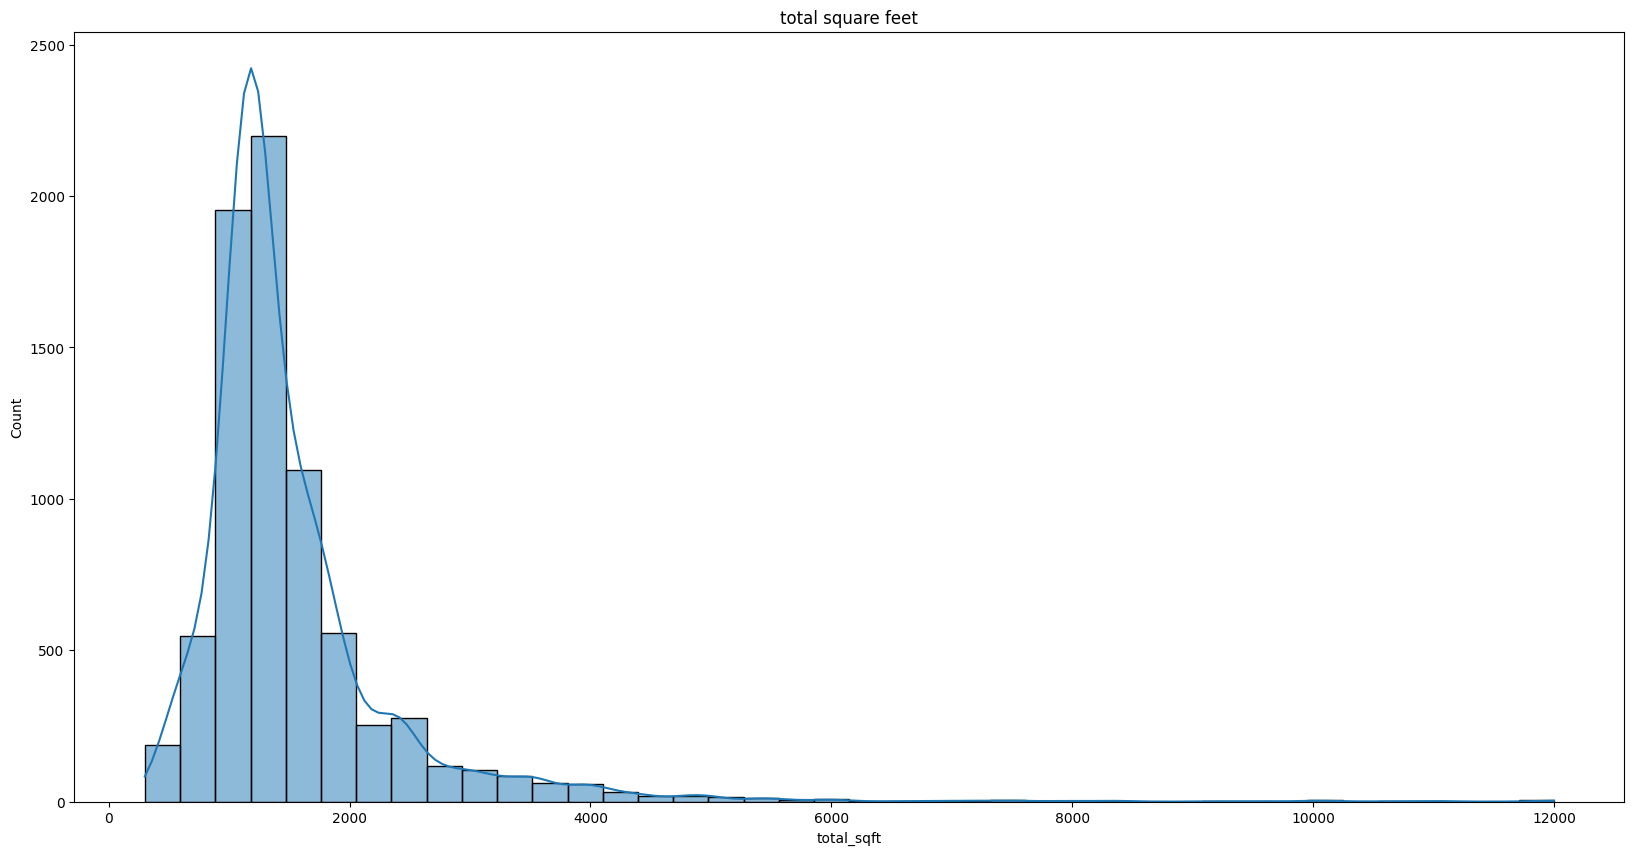

In [186]:
# total square feet
plt.figure(figsize=(20,10))
sns.histplot(df['total_sqft'], kde=True, bins=40)
plt.title('total square feet')
plt.show()

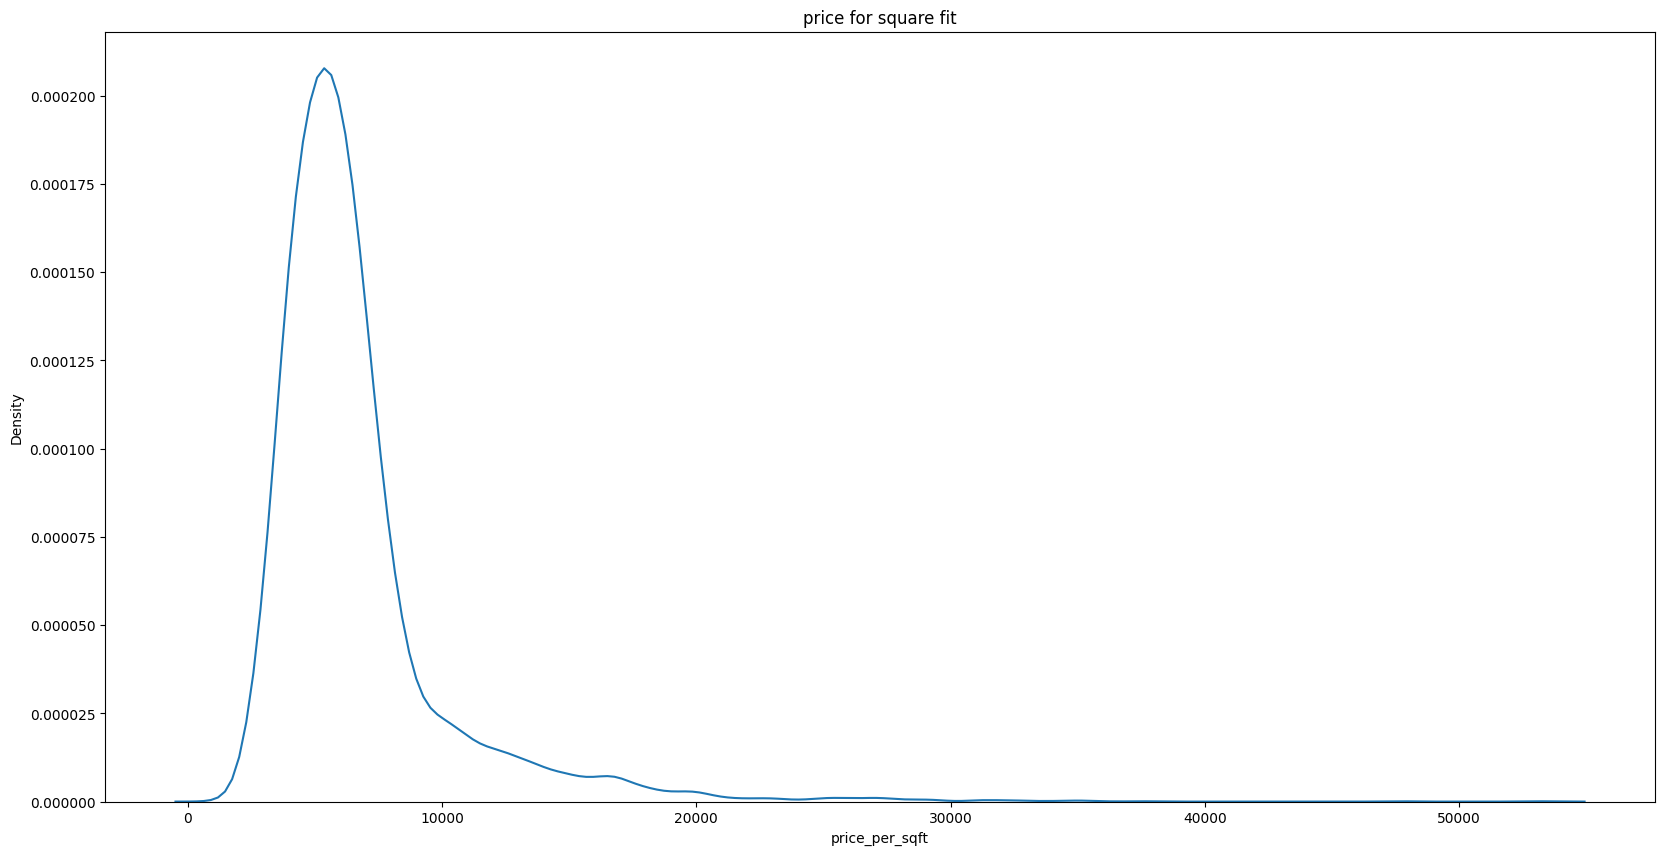

In [187]:
# price for square fit
plt.figure(figsize=(20,10))
sns.kdeplot(df['price_per_sqft'])
plt.title('price for square fit')
plt.show()

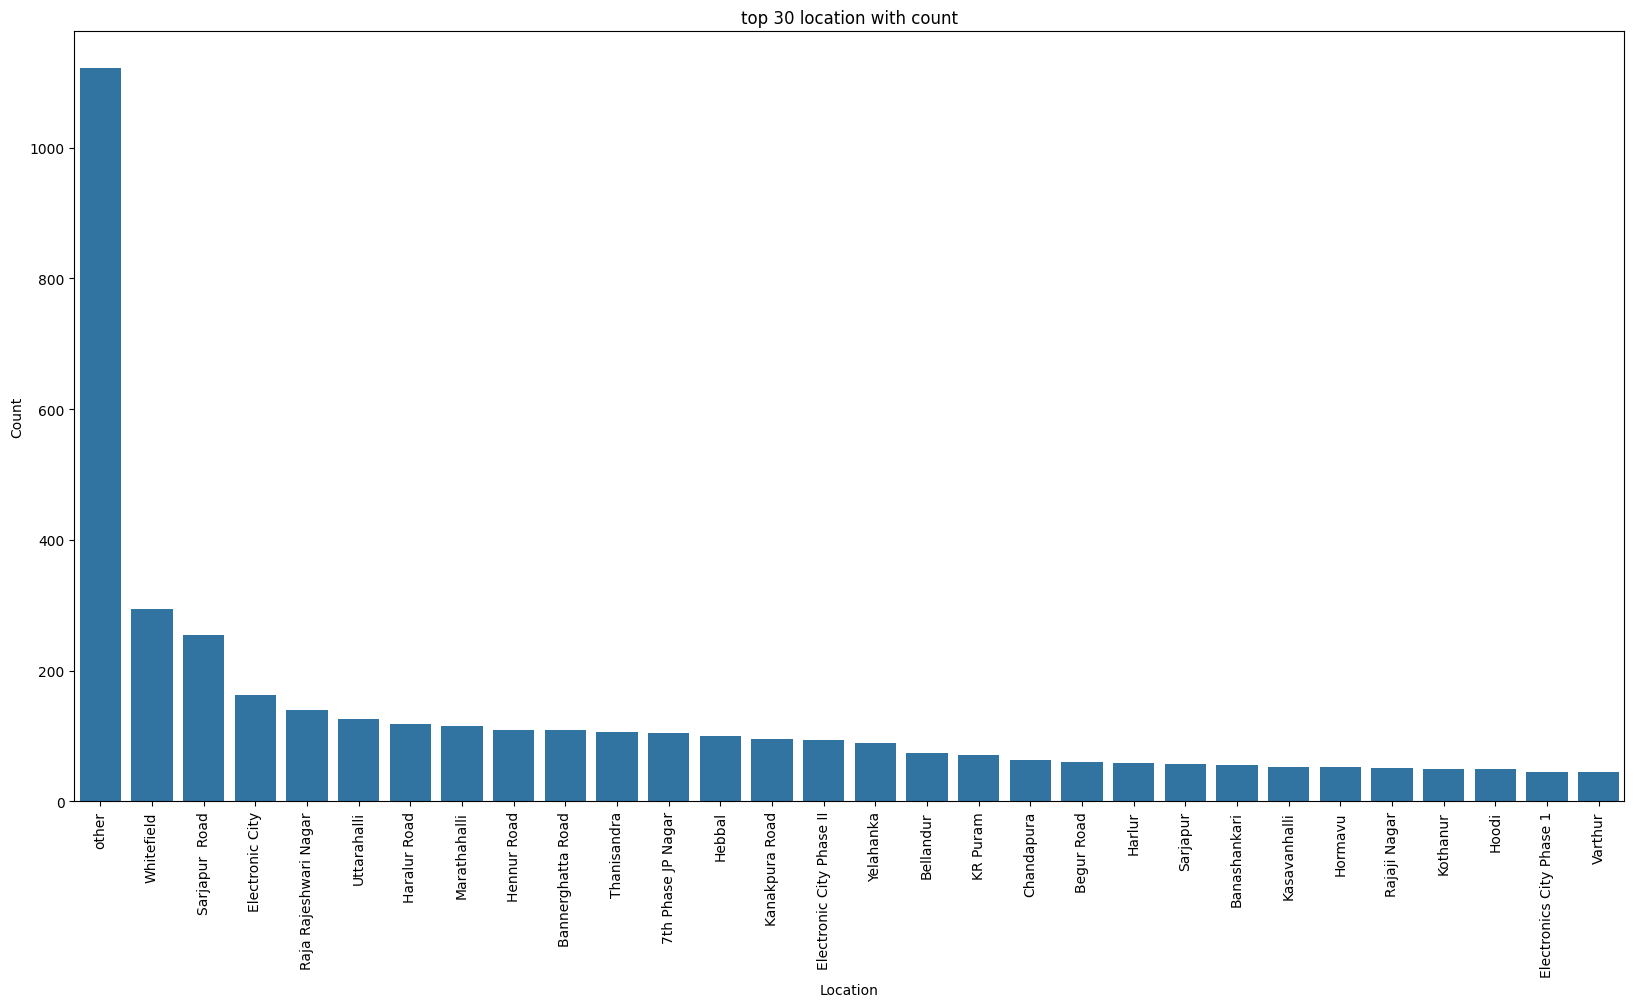

In [188]:
# top 30 location with count
location_counts = df['location'].value_counts().head(30)

plt.figure(figsize=(20,10))
sns.barplot(x=location_counts.index, y=location_counts.values)
plt.xticks(rotation=90)
plt.title('top 30 location with count')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

Model Buiulding

In [189]:
# convert categorical to onehot encoding
df = pd.get_dummies(df, drop_first=True)

In [190]:
# remove price per sqft
df.drop(columns=['price_per_sqft'], inplace=True)

In [191]:
X = df.drop(columns=['price'])
y = df['price']

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

In [210]:
lr = LinearRegression()
lr.fit(X_train, y_train)

lr.score(X_test, y_test)

0.7290885130756414

In [211]:
# using ridge
ridge = Ridge()
ridge.fit(X_train, y_train)

ridge.score(X_test, y_test)

0.7371108933414809

In [212]:
# using lasso
lasso = Lasso()
lasso.fit(X_train, y_train)

lasso.score(X_test, y_test)

0.7101005159269642

In [226]:
import numpy as np
from sklearn.linear_model import LinearRegression

def predict_price(location, sqft, bath, bhk):
    try:
        x = np.zeros(len(X.columns))

        x[0] = sqft
        x[1] = bath
        x[2] = bhk


        loc_columns = [col for col in X.columns if location in col]
        if len(loc_columns) > 0:
            loc_index = X.columns.get_loc(loc_columns[0])
            x[loc_index] = 1

        return lr.predict([x])[0]
    except Exception as e:
        return f"Error: {str(e)}"

# usage
lr = LinearRegression()
lr.fit(X_train, y_train)

# Prediction example
print(predict_price("1st Phase JP Nagar", 1500, 3, 2))

128.08274472584054


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
